In [ ]:
# !git clone https://github.com/Jsrsky/machine_unlearning_experiments
# %cd machine_unlearning_experiments/experiments/mnist/fisher

## Dependecies

In [13]:
from pathlib import Path
import sys
import copy
from torchvision import datasets

## Utils 


In [14]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: d:\Machine_unlearning_masters


In [28]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.simple_cnn import load_model_cnn, init_model_cnn

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import compute_fisher_matrix, fisher_unlearning, create_unlearning_dataloader

Device used: cpu


## Parameters (arbitrary chosen)

In [16]:
BATCH_SIZE = 32
MINI_BATCH_SIZE = BATCH_SIZE

SIGMA = 1.0

# CALL FISHER

### Files

In [22]:
model_file = project_root / 'experiments/mnist/naive/CNN_MNIST_model.pth'
samples_to_unlearn_file = project_root / 'experiments/mnist/naive/mnist_samples_to_unlearn.json'
remaining_dataset_file = project_root / 'experiments/mnist/naive/updated_mnist_data_splits.json'

### Init models

In [18]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_cnn(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
model_to_unlearn_name = 'fisher_' + original_model_name

Load model...
Init model...
Done initializing model.
Model ID: 2484302462944, Optimizer ID: 2484302782608, Criterion ID: 2484302780640
Done loading model.


## Init data

In [19]:
dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)

In [23]:
train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
    data_splits_file=remaining_dataset_file,
    dataset=dataset, 
    batch_size=BATCH_SIZE)

unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, dataset, batch_size = MINI_BATCH_SIZE)

Recreating DataLoaders...
Done recreating DataLoaders.


### FIM

In [24]:
fim = compute_fisher_matrix(model_to_unlearn, train_loader, criterion)

Calculating FIM...: 100%|██████████| 1351/1351 [01:09<00:00, 19.56it/s]


### Unlearn

In [25]:
unlearned_model = fisher_unlearning(model_to_unlearn, unlearn_loader, fim, criterion, sigma=SIGMA)

Unlearning Process...: 100%|██████████| 188/188 [00:11<00:00, 15.94it/s]


In [ ]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model.pth')

### Test and metrics

In [30]:
model, *_ = init_model_cnn()
model_path = f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)

Init model...
Done initializing model.
Model ID: 2484303159248, Optimizer ID: 2484303153392, Criterion ID: 2484303151184
Loading and testing model: fisher_CNN_MNIST


Evaluating model: fisher_CNN_MNIST_model.pth: 100%|██████████| 313/313 [00:08<00:00, 36.63it/s]

Predictions and labels saved to fisher_CNN_MNIST_predictions.json


c:\Users\bleed\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics for fisher_CNN_MNIST:
  - Test Accuracy: 0.1001
  - Precision: 0.0100
  - Recall: 0.1001
  - F1 Score: 0.0182


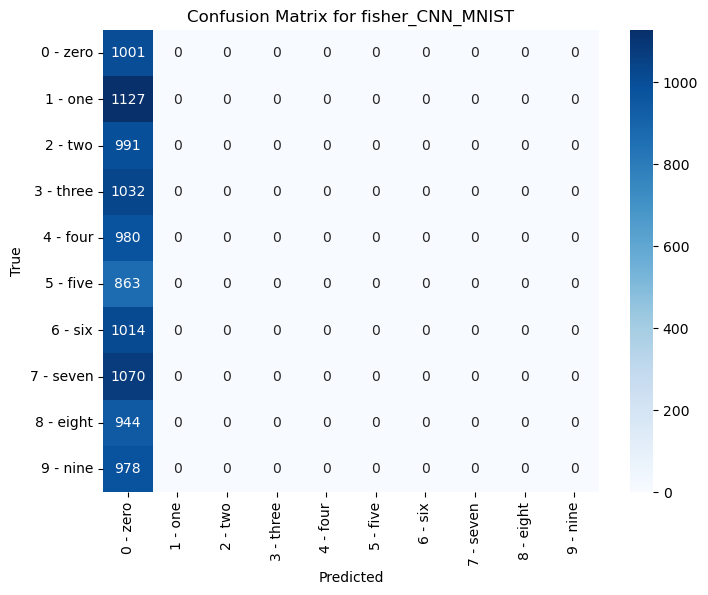

In [31]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
# classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
show_metrics(predictions_path, classes, model_to_unlearn_name)